In [1]:
from scipy.stats import qmc, norm, truncnorm
import numpy as np

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

mpl.rcParams.clear()
mpl.rcParams.update(
    {
        "font.family": "serif",
        "lines.linewidth": 0.5,
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
    }
)

In [3]:
mean = 30  # Mean
std = 5  # Standard deviation
sample_num = 1000  # Number of samples

In [4]:
# LatinHyperCube
lhc = qmc.LatinHypercube(d=1, optimization="random-cd").random(n=sample_num)
sample_lhc = norm(loc=mean, scale=std).ppf(lhc)

# Monte Carlo (random numbers)
sample_mc = norm.rvs(loc=mean, scale=std, size=sample_num)

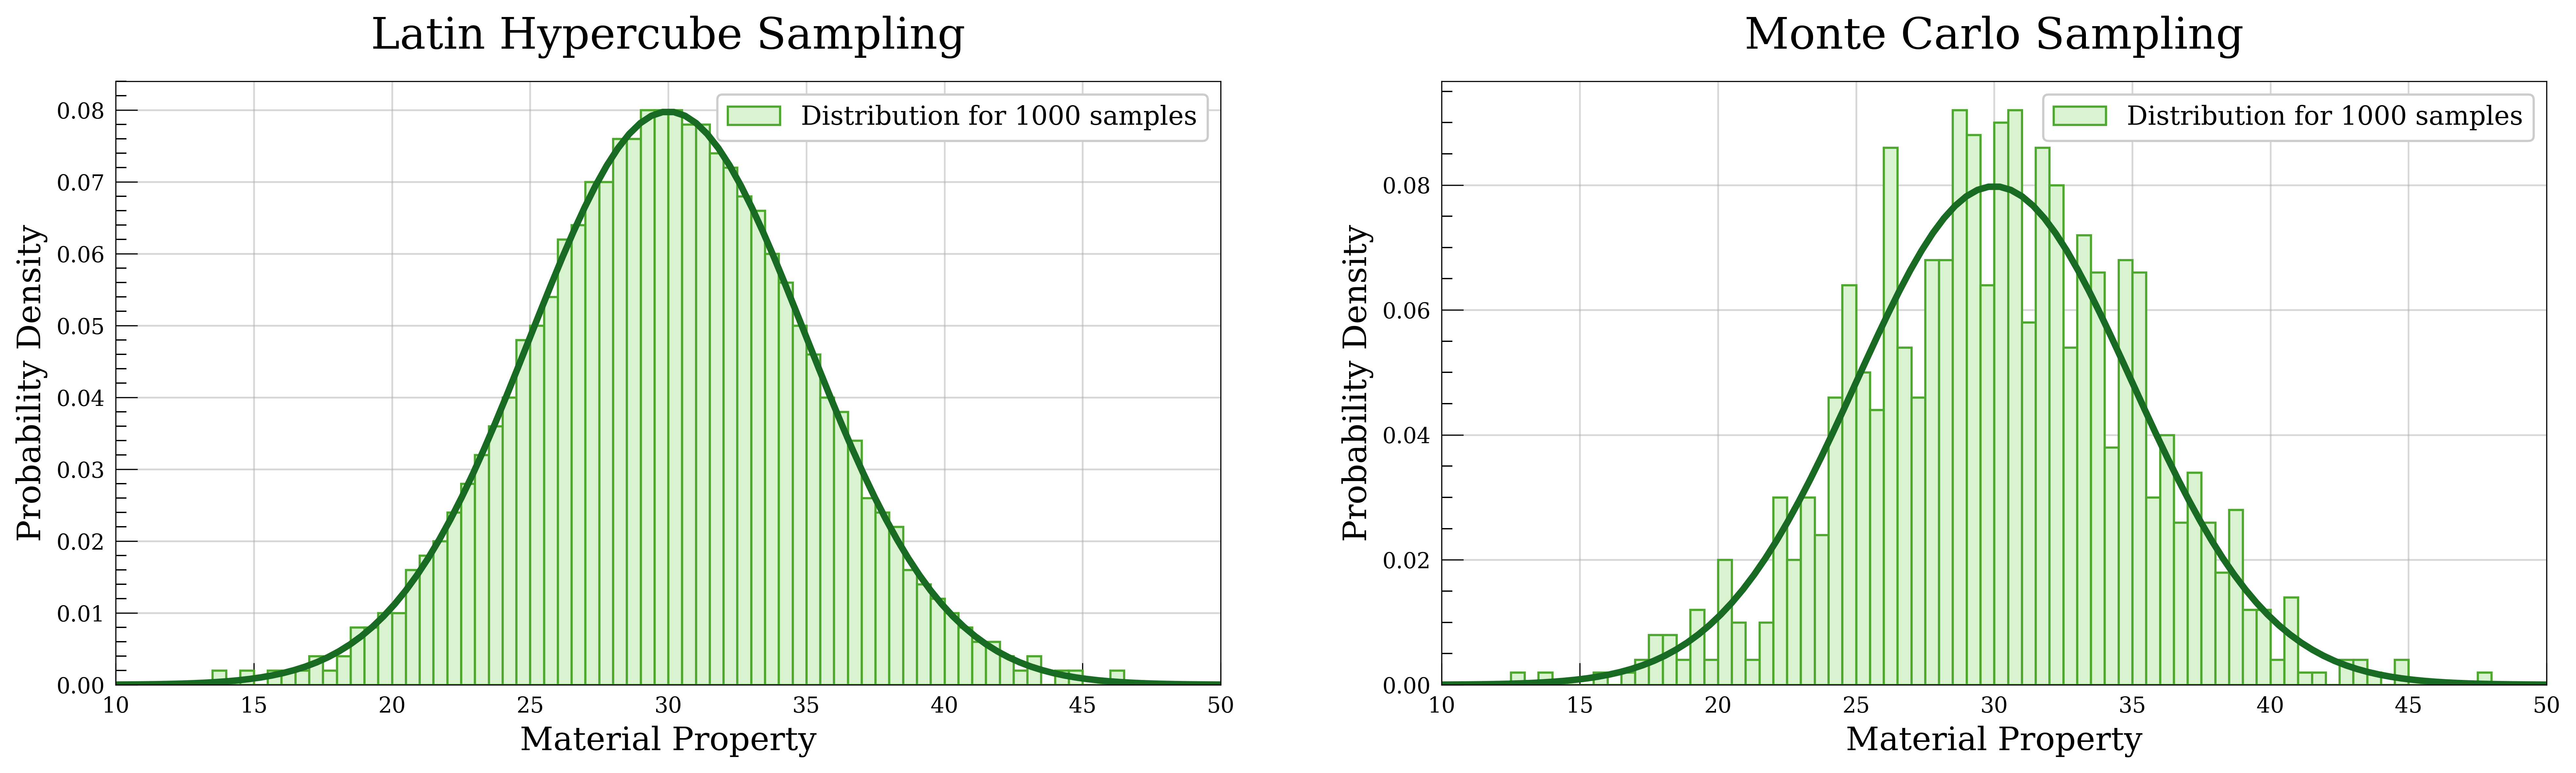

In [5]:
xmin = mean - 4 * std
xmax = mean + 4 * std
bins = int(xmax - xmin) * 2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), dpi=480)

ax1.hist(
    sample_lhc,
    bins=bins,
    color="#D9F2D0",
    rwidth=1,
    density=True,
    range=(xmin, xmax),
    edgecolor="#4EA72E",
    label=f"Distribution for {sample_num} samples",
)
ax2.hist(
    sample_mc,
    bins=bins,
    color="#D9F2D0",
    rwidth=1,
    density=True,
    range=(xmin, xmax),
    edgecolor="#4EA72E",
    label=f"Distribution for {sample_num} samples",
)

x = np.linspace(xmin, xmax, 100)
for ax in [ax1, ax2]:
    ax.plot(x, norm.pdf(x, loc=mean, scale=std), color="#196B24", lw=3)
    ax.set_xlim((xmin, xmax))
    ax.set_xlabel("Material Property", fontsize=15)
    ax.set_ylabel("Probability Density", fontsize=15)

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x", direction="in", length=10, colors="k", pad=5)
    ax.tick_params(axis="y", direction="in", length=10, colors="k", pad=5)
    ax.tick_params(axis="x", which="minor", direction="in", length=5, colors="k")
    ax.tick_params(axis="y", which="minor", direction="in", length=5, colors="k")

    ax.grid(alpha=0.5)
    ax.set_axisbelow(True)

    ax.legend(fontsize=12, framealpha=1)

ax1.set_title("Latin Hypercube Sampling", fontsize=20, pad=15)
ax2.set_title("Monte Carlo Sampling", fontsize=20, pad=15)


plt.show()

In [6]:
vertices = [
    (0, 0),
    (0, 20),
    (30, 20),
    (60, 40),
    (160, 40),
    (160, 0),
]  # Polygon vertices
cx = 10  # Correlation lenght in X
cy = 1  # Correlation lenght in Y
mesh_size = 2  # Triangular mesh size

In [7]:
import pygmsh

# Definir los vértices del polígono
vertices = [(0, 0), (0, 20), (30, 20), (60, 40), (160, 40), (160, 0)]

with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(
        vertices,
        mesh_size=mesh_size,
    )
    mesh = geom.generate_mesh()

points = mesh.points
triangles = mesh.cells_dict["triangle"]

In [8]:
n = len(points)
var = np.full((n, n), std**2)

x = points[:, 0]
y = points[:, 1]

cov_matrix = (
    var
    * np.exp(-np.pi * (abs((x[:, None] - x[None, :])) / cx) ** 2)
    * np.exp(-np.pi * (abs((y[:, None] - y[None, :])) / cy) ** 2)
)

mean = np.full((len(points),), 30)

# values = np.random.multivariate_normal(mean, cov_matrix) , slowly method
values = mean + np.linalg.cholesky(cov_matrix) @ np.random.standard_normal(
    mean.size
)  # fast method

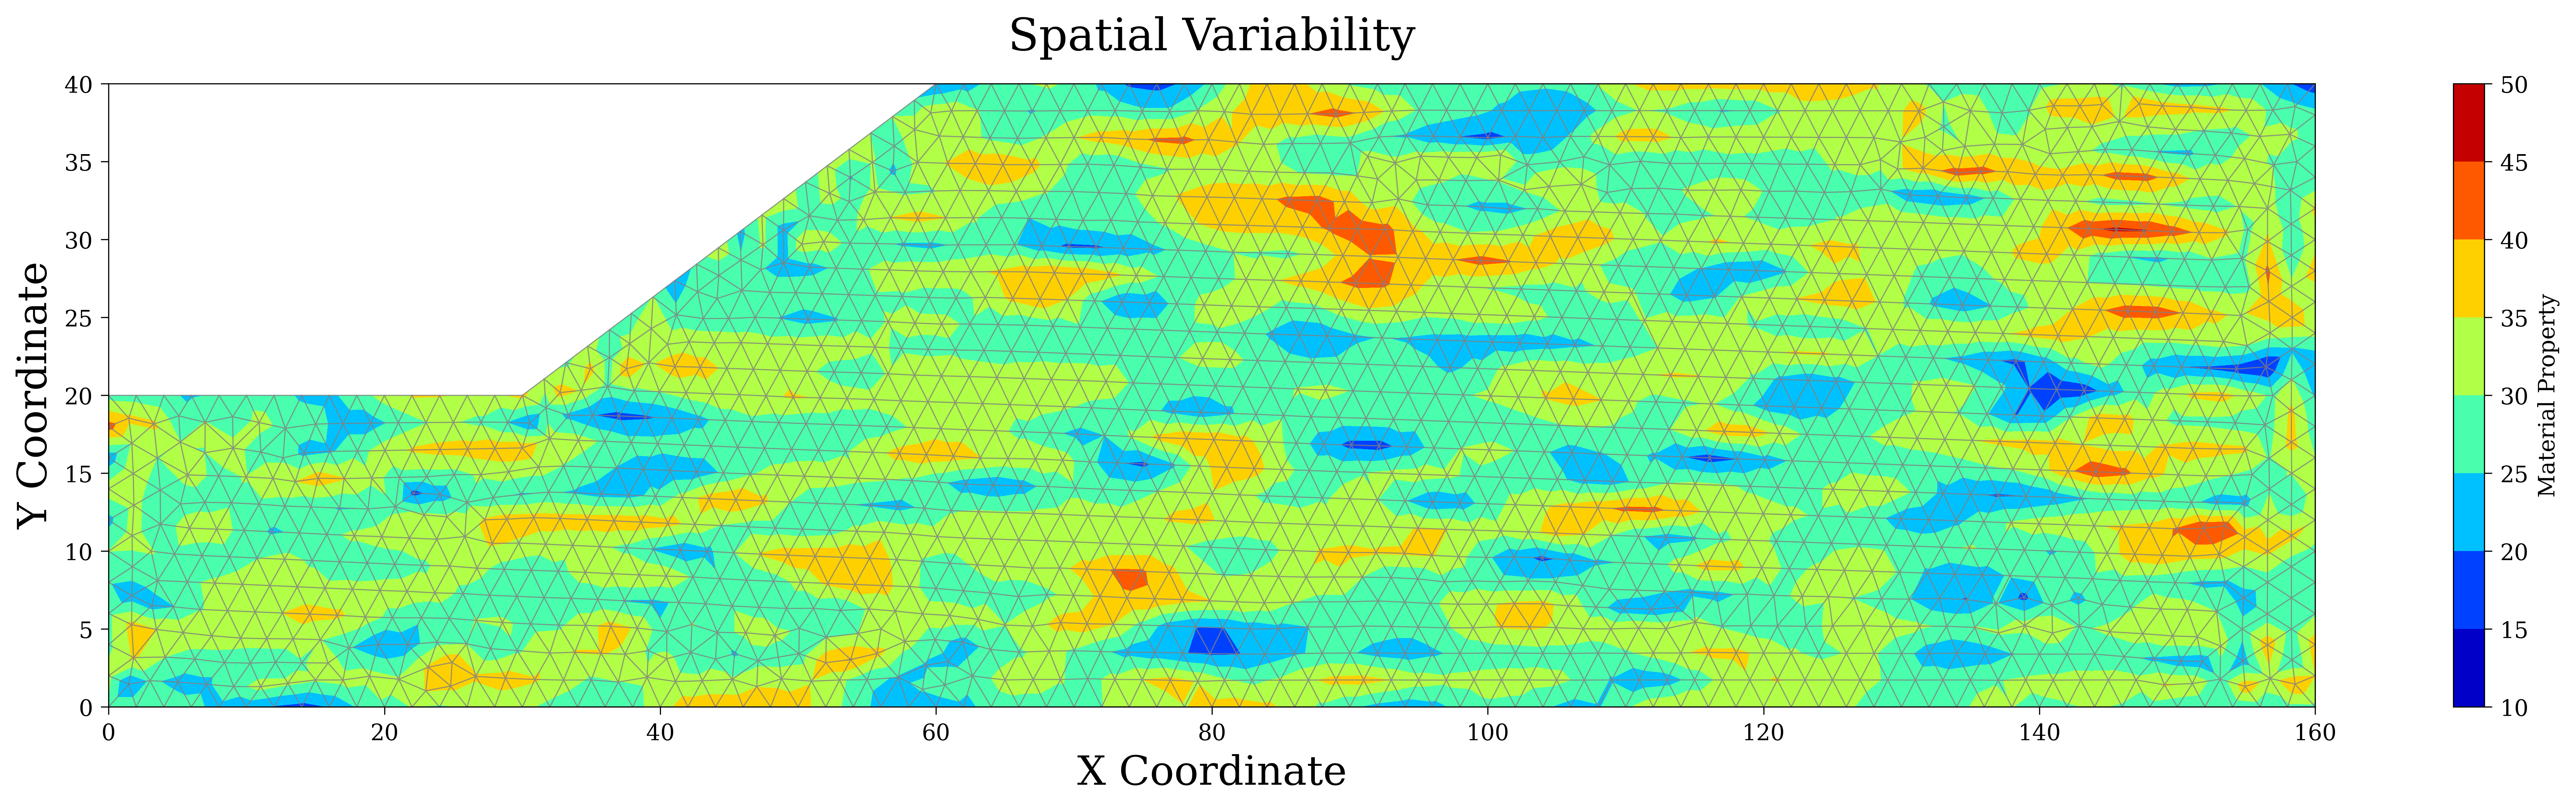

In [9]:
fig, ax = plt.subplots(figsize=(22, 5), dpi=480)

surf = ax.tricontourf(points[:, 0], points[:, 1], triangles, values, cmap="jet")
ax.triplot(points[:, 0], points[:, 1], triangles, color="gray", alpha=0.8, lw=0.5)


fig.colorbar(surf, ax=ax, orientation="vertical", label="Material Property")

ax.set_xlabel("X Coordinate", fontsize=18)
ax.set_ylabel("Y Coordinate", fontsize=18)
ax.set_title("Spatial Variability", fontsize=20, pad=15)

plt.show()